In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import src.utilerias.reader as rd
import src.utilerias.utilerias as utls

# Llamamos a la función antes de ejecutar el script
logs_dir = 'logs/NARNN/estandar'
logs_dir_auto_pred = 'logs/NARNN/auto_predictiva'
utls.eliminar_archivos_registro(logs_dir)
utls.eliminar_archivos_registro(logs_dir_auto_pred)

In [2]:
# DATOS = 'cierre.csv'#Grupo Financiero Inbursa
# DATOS = 'Datos históricos COMI 03012016_27122020.csv' #Datos originales
# DATOS = 'datos/Datos históricos COMI 3ene16-31dic2020 semanal.csv' #Datos semanales
# DATOS = 'Datos históricos COMI_prueba 30jun19-31dic2020.csv' #Datos semanales de prueba
# DATOS = 'Datos históricos COMI3ene2016_27dic2020_diario.csv' #Datos originales diarios de prueba
# DATOS = 'Datos históricos COMI_prueba 30jun19-31dic2020_DIARIO.csv' #Datos diarios de prueba
DATOS = 'datos\_nacionales\entidades financieras\ACTINVRB\_030116_ 311223.csv'

cierre = rd.leer_archivo(DATOS).astype(float)

In [3]:
#Se crean los conjuntos de entradas y salidas para la red, que funcionaran para predecir y comparar con las salidas esperadas a la hora de realizar el entrenamiento
time_steps = 8 # la cantidad de semanas anteriores a partir de las cuales se va a predecir la novena semana

#Se comenta el primer y descomenta el segundo para muestreo aleatorio

#Obtenemos el conjunto de entrenamiento
c_entrenamiento = np.array(cierre[:int(len(cierre) * 0.7)])

precios_reales = cierre[int(len(cierre) * 0.7):] #verdaderos valores del conjunto de prueba

#Se concatenan los ultimo 8 elementos del conjunto de entrenamiento para predecir el primero del conjunto de prueba
# ahora cada uno de los arreglos dentro de components_p y components_p_n tiene forma (84,)
c_prueba = cierre[len(cierre) - len(precios_reales) - time_steps:]

# # Genera índices aleatorios únicos y ordenados
# indices_aleatorios = np.sort(np.random.choice(len(cierre), size=int(0.3 * len(cierre)) + 8, replace=False))
# # Selecciona los elementos correspondientes a los índices ordenados
# c_prueba = cierre[indices_aleatorios]
# # Calcula los índices del 70% restante (complemento del conjunto del 30%)
# indices_restantes = np.setdiff1d(np.arange(len(cierre)), indices_aleatorios)
# # Selecciona los elementos correspondientes a los índices restantes
# c_entrenamiento = cierre[indices_restantes]



#Se normalizan cada uno de los elementos de los vectores contenidos en las descomposicion de la serie de tiempo original
c_entrenamiento_n = utls.normalizar(c_entrenamiento) # componentes de entrenamiento normalizados
c_prueba_n = utls.normalizar(c_prueba) # componentes de prueba normalizados len 78

In [4]:
from src.modelos.auto_regresivo.NARNN.NARNN import NARNN
from src.modelos.auto_regresivo.entrenamientos.entrenamiento import Entrenamiento as entr

red = NARNN(t_entrada=8, t_salida=1, nombre="NARNN")
red.load_state_dict(torch.load('redes/NARNN/estandar/ACTINVRB/red_NARNN_lr0-04_e30.pth'))
red.eval()

entrenamiento_8_1 = [[]]
prueba_8_1 = [[]]

# A cada uno de los conjuntos de entrenamiento se les da una forma de entrada en especifico,
# que es un arreglo de 8 y uno de un solo elemento para representar la salida

entrenamiento_8_1[0] = utls.corrimiento_t_1(c_entrenamiento_n,9) # list(tensor[()]*) una lista de 174 tensores con 9 elementos cada uno
prueba_8_1[0] = utls.corrimiento_t_1(c_prueba_n,9) # list(tensor[()]*) una lista de 78 tensores con 9 elementos cada uno

In [5]:
# Definimos el número de epocas
EPOCAS = 60
LR = 0.04

In [6]:
# Se realiza el entrenamiento de cada una de las redes y se guarda el modelo ya entrenado

# entr_red = entr(red,0,writer_dir=logs_dir)
# entr_red.entrena_lm(entrenamiento_8_1[0],epocas=EPOCAS,lr=LR,λ=0.1,e_predictivo=False)
#torch.save(red.state_dict(), 'redes/NARNN/estandar/red_NARNN.pth') #Salvamos el estado actual del modelo

# Cerrar el escritor
# entr_red.cerrar_escritor()

# Predicción del conjunto de prueba

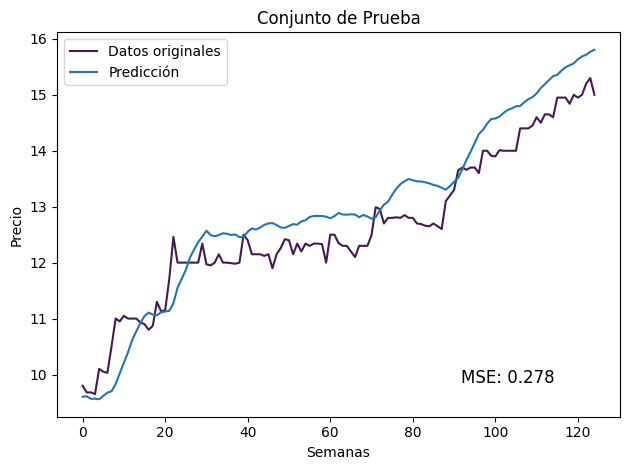

In [7]:
#Se grafica el conjunto de entrenamiento
criterion = nn.MSELoss()

prediccion = utls.genera_prediccion_1(prueba_8_1[0],red,8)
precios_predichos = utls.desnormalizar(prediccion,np.max(c_prueba),np.min(c_prueba)).detach().numpy()
# le quitamos los primeros 8 elementos
precios_predichos = precios_predichos[time_steps:]
plt.plot(c_prueba[time_steps:], color = '#451952', label = 'Datos originales') 
plt.plot(precios_predichos, label = 'Predicción')
plt.title('Conjunto de Prueba')
plt.xlabel('Semanas')
plt.ylabel('Precio')
plt.text(0.8, 0.1, f"MSE: {round(float(criterion(torch.tensor(precios_predichos), torch.tensor(c_prueba[time_steps:]))),4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)

plt.legend()

plt.tight_layout()
plt.show()

# Evaluación de desempeño

In [8]:
import pandas as pd
r_c_prueba_txt = 'Precicción de c_prueba'
# Supongamos que tenemos una lista de errores de predicción para cada red neuronal
rmse = {
    r_c_prueba_txt: utls.rmse(c_prueba[time_steps:],precios_predichos)
}
mape = {
    r_c_prueba_txt: utls.mape(c_prueba[time_steps:],precios_predichos)
}
ds = {
    r_c_prueba_txt: utls.directional_symmetry(c_prueba[time_steps:],precios_predichos)
}

# Creamos un DataFrame de Pandas a partir del diccionario de errores
df_errores = pd.DataFrame({
    'RMSE': pd.Series(rmse),
    'MAPE': pd.Series(mape),
    'DS': pd.Series(ds)
})

# Mostramos el DataFrame con los errores
print(df_errores) 


                            RMSE    MAPE    DS
Precicción de c_prueba  0.527226  3.7285  57.6


# Generamos el entrenamiento predictivo

In [9]:
# Definimos el número de epocas
EPOCAS = 60
LR = 0.05
DF= 0.5
BS = 8

In [10]:
#model_path = f'redes/NARNN/auto_predictiva/{"ACTINVRB/red_NARNN_lr0-018_e30.pth"}'
red.load_state_dict(torch.load('redes/NARNN/auto_predictiva/ACTINVRB/red_NARNN_lr0.06_e30_bs8_df0.5.pth'))
#red.load_state_dict(torch.load(model_path))
red.eval()

# str_conj_datos = 'ACTINVRB'

# entr_red_pred = entr(red,0, logs_dir_auto_pred)
# entr_red_pred.entrena_lm(entrenamiento_8_1[0],EPOCAS,lr=LR,λ=0.1,batch_size=8,decay_factor=DF,e_predictivo=True)
# torch.save(red.state_dict(), f'redes/NARNN/auto_predictiva/{str_conj_datos}/red_NARNN_lr{LR}_e{EPOCAS}_bs{BS}_df{DF}.pth') #Salvamos el estado actual del modelo

# # Cerrar el escritor
# entr_red_pred.cerrar_escritor()

NARNN(
  (fc1): Linear(in_features=8, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

In [11]:
# Predice el conjunto de entrenamiento usando la prediccion predictiva a partir de los primeros (usando los datos que predice)
prediccion_ap = utls.genera_prediccion_predictiva(prueba_8_1[0][0][:8],8,len(prueba_8_1[0]),red)
red_ap_precios_predichos = utls.desnormalizar(prediccion_ap,np.max(c_prueba),np.min(c_prueba)).detach().numpy()
# omitimos los primeros 8 elementos
red_ap_precios_predichos = red_ap_precios_predichos[time_steps:]

C:\Users\MALIERA.ADCONSAR\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([125])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


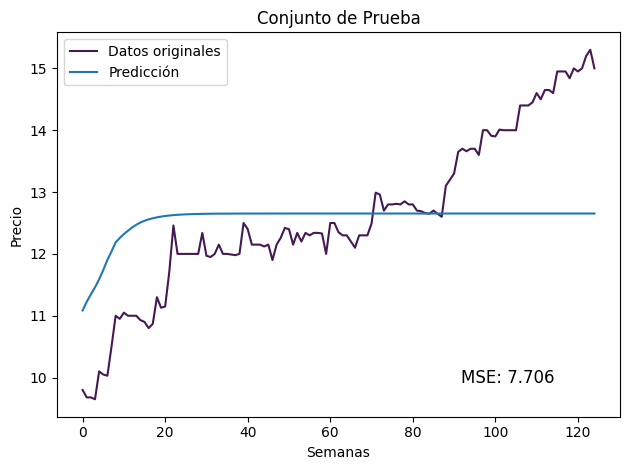

In [12]:

plt.plot(c_prueba[time_steps:], color = '#451952', label = 'Datos originales')
plt.plot(red_ap_precios_predichos, label = 'Predicción')#label=f"Datos de Analisis: {DATOS}",
plt.title('Conjunto de Prueba')
plt.xlabel('Semanas')
plt.ylabel('Precio')
plt.text(0.8, 0.1, f"MSE: {round(float(criterion(torch.tensor(red_ap_precios_predichos), torch.tensor(c_prueba[time_steps]))),4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
import pandas as pd
r_c_prueba_txt = 'Precicción de c_prueba'
# Supongamos que tenemos una lista de errores de predicción para cada red neuronal
rmse = {
    r_c_prueba_txt: utls.rmse(c_prueba[time_steps:],red_ap_precios_predichos)
}
mape = {
    r_c_prueba_txt: utls.mape(c_prueba[time_steps:],red_ap_precios_predichos)
}
ds = {
    r_c_prueba_txt: utls.directional_symmetry(c_prueba[time_steps:],red_ap_precios_predichos)
}

# Creamos un DataFrame de Pandas a partir del diccionario de errores
df_errores = pd.DataFrame({
    'RMSE': pd.Series(rmse),
    'MAPE': pd.Series(mape),
    'DS': pd.Series(ds)
})

# Mostramos el DataFrame con los errores
print(df_errores) 

                            RMSE    MAPE    DS
Precicción de c_prueba  1.173393  7.3947  76.8


Acotamos el conjunto de predicciones a solo las n primeras semanas, a fin de ser más justos en el analisis.

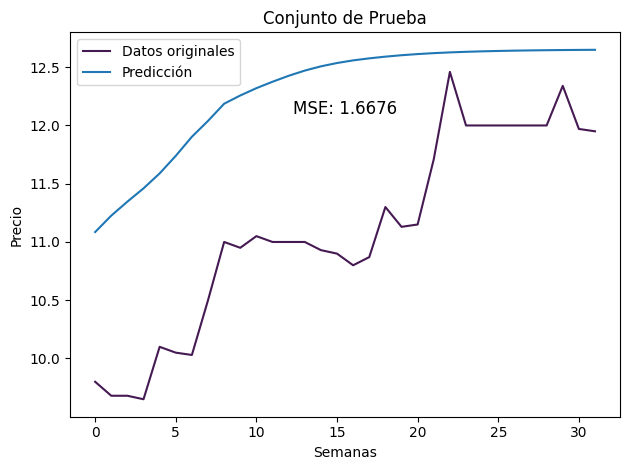

                            RMSE     MAPE     DS
Precicción de c_prueba  1.291369  11.1665  56.25


In [14]:
cota_semanas = 32

plt.plot(c_prueba[time_steps:time_steps + cota_semanas], color = '#451952', label = 'Datos originales')
plt.plot(red_ap_precios_predichos[:cota_semanas], label = 'Predicción')#label=f"Datos de Analisis: {DATOS}",
plt.title('Conjunto de Prueba')
plt.xlabel('Semanas')
plt.ylabel('Precio')
plt.text(0.5, 0.8, f"MSE: {round(float(criterion(torch.tensor(red_ap_precios_predichos[:cota_semanas]), torch.tensor(c_prueba[time_steps:time_steps + cota_semanas]))),4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
plt.legend()

plt.tight_layout()
plt.show()

rmse = {
    r_c_prueba_txt: utls.rmse(c_prueba[time_steps:time_steps + cota_semanas],red_ap_precios_predichos[:cota_semanas])
}
mape = {
    r_c_prueba_txt: utls.mape(c_prueba[time_steps:time_steps + cota_semanas],red_ap_precios_predichos[:cota_semanas])
}
ds = {
    r_c_prueba_txt: utls.directional_symmetry(c_prueba[time_steps:time_steps + cota_semanas],red_ap_precios_predichos[:cota_semanas])
}

# Creamos un DataFrame de Pandas a partir del diccionario de errores
df_errores = pd.DataFrame({
    'RMSE': pd.Series(rmse),
    'MAPE': pd.Series(mape),
    'DS': pd.Series(ds)
})

# Mostramos el DataFrame con los errores
print(df_errores) 